In [1]:
from timeit import default_timer as timer
import pandas as pd
import scipy.stats
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import calendar
import time
%matplotlib inline
start_time = timer()

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/Shawn-zou-2020/MyProjects/main/Fraud%20Analysis/Card%20Transaction%20Fraud%20Analysis/Raw%20Data/card%20transactions.csv')

In [3]:
data.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud
0,1,5142190439,2006-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0
1,2,5142183973,2006-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0
2,3,5142131721,2006-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0
3,4,5142148452,2006-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0
4,5,5142190439,2006-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0


### Fix Data Type

In [4]:
data.dtypes

Recnum                 int64
Cardnum                int64
Date                  object
Merchnum              object
Merch description     object
Merch state           object
Merch zip            float64
Transtype             object
Amount               float64
Fraud                  int64
dtype: object

In [5]:
data['Date']=pd.to_datetime(data.Date)

### Data Cleaning

#### Remove some records

In [6]:
# keep only P type
data=data.loc[data['Transtype']=='P']

In [7]:
data.describe()

,Recnum,Cardnum,Merch zip,Amount,Fraud
count,96398.000000,9.639800e+04,92097.000000,9.639800e+04,96398.000000
mean,48365.526940,5.142202e+09,44706.596740,4.280340e+02,0.010986
std,27944.862446,5.565798e+04,28369.537945,1.002446e+04,0.104236
min,1.000000,5.142110e+09,1.000000,1.000000e-02,0.000000
25%,24154.250000,5.142152e+09,20855.000000,3.346000e+01,0.000000
50%,48365.500000,5.142196e+09,38118.000000,1.379800e+02,0.000000
75%,72577.750000,5.142245e+09,63103.000000,4.282500e+02,0.000000
max,96753.000000,5.142847e+09,99999.000000,3.102046e+06,1.000000


In [8]:
# remove outlier
data=data.loc[~(data['Amount']==data['Amount'].max())]

In [9]:
data.describe()

,Recnum,Cardnum,Merch zip,Amount,Fraud
count,96397.000000,9.639700e+04,92097.000000,96397.000000,96397.000000
mean,48365.481820,5.142202e+09,44706.596740,395.858494,0.010986
std,27945.003883,5.565825e+04,28369.537945,832.330197,0.104236
min,1.000000,5.142110e+09,1.000000,0.010000,0.000000
25%,24154.000000,5.142152e+09,20855.000000,33.460000,0.000000
50%,48365.000000,5.142196e+09,38118.000000,137.980000,0.000000
75%,72578.000000,5.142245e+09,63103.000000,428.250000,0.000000
max,96753.000000,5.142847e+09,99999.000000,47900.000000,1.000000


D:\ana\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Amount'>

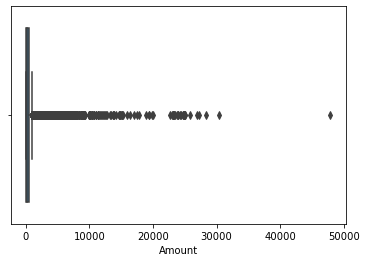

In [10]:
sns.boxplot(data['Amount'])

#### Fill in Merchnum

In [11]:
data[data['Merchnum']=='0'].head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud
817,818,5142230669,2006-01-06,0,TOMMY'S TRAILERS,OK,NaN,P,48.97,0
1221,1222,5142231496,2006-01-07,0,TOMMY'S TRAILERS,OK,NaN,P,87.02,0
1402,1403,5142159706,2006-01-07,0,INTERACTIVE SOFTWARE S,NaN,NaN,P,460.00,0
2089,2090,5142243966,2006-01-11,0,ESTUARINE RESEARCH FDRTN,MD,20676.0,P,25.00,0
2168,2169,5142141358,2006-01-11,0,REED BUSINESS PUBLISHI,NaN,NaN,P,110.00,0


In [12]:
#Find the most common (mode) Merchnum over all records that have the particular Merch description
def top_value_count (x, n=1) :
    return x.value_counts().head(n)
df_description = data.groupby(['Merch description']).Merchnum 
merch_map = df_description.apply(top_value_count).reset_index()
merch_map.rename (columns=dict(level_1='Merchnum', Merchnum=' count_Merchnum'), inplace=True)

In [13]:
merch_map

,Merch description,Merchnum,count_Merchnum
0,#9 SOFTWARE,6000330882278,2
1,(ISC)2 CERTIFICATION,590065510,1
2,0000000000000000000000,8168600400097,3
3,033007 KINKO'S,35068136338,5
4,05032 FLYING J,121075089FL96,1
...,...,...,...
12478,ZYMARK CORPORATION,988906278331,6
12479,ZYMAX ENVIROTECHNOLOGY,9612006916900,2
12480,ZYMED LABORATORIES,679966068337,11
12481,ZZYZX WORKSTATIONS,6163608306809,3


In [14]:
# match with the mode merchnum with a particular Merch description
merchdes_merchnum = {}
for index, merchdes in merch_map[merch_map['Merch description'].notnull()]['Merch description'].items():
    #print(index,merchdes)
    if merchdes not in merchdes_merchnum :
        merchdes_merchnum[merchdes] = merch_map.loc[index, 'Merchnum']

In [15]:
for index, merchdes in merch_map[merch_map['Merch description'].notnull()]['Merch description'].items():
    print(index,merchdes)

0 #9 SOFTWARE
1 (ISC)2 CERTIFICATION
2 0000000000000000000000
3 033007 KINKO'S
4 05032 FLYING J
5 072001 KINKO'S
6 079001 KINKOS OLYMPIA
7 1 HOUR MOTO PHOTO
8 1 ST COMPU CHOICE
9 1-800 MOBILES
10 1-800-HITCH-IT
11 1-ON-1/WORKING SMARTER
12 1000 FRIENDS OF OREGON
13 101 HITCH & RENTAL
14 1010 NET.COM CORP
15 103 PRINTS PLUS
16 123 COMPUTER SUPPLIES INC
17 1ST VOICE
18 2 FOR 1 INKJET COM
19 20TH CENTURY PLASTICS
20 3-D MARKETING
21 365USA / XIT, INC.
22 3A MARINE SERVICE INC
23 3COM   *CORPORATION
24 3D COMPUTER AND GAMING IN
25 3M-PRODUCTS
26 42ND STREET PHOTO
27 46130 US DIST COURT
28 7 CORNER/TOOLS ON SALE
29 7 CORNERS ACE HARDWARE
30 800-231-5820 SS *PORT. PR
31 800-INSIGHT
32 8886538103 PREFBUYERRE
33 8AOFFICEPRODUCTS.CO
34 99 CENTS ONLY #94
35 A  AND  B LABS
36 A & A INDUSTRIAL SUPPLY
37 A & A TOPPER SALES
38 A & B LOCK & KEY
39 A & B SECURITY GROUP
40 A & P #42
41 A 1 ELECTRIC MOTOR
42 A 1 RENTAL
43 A A A R
44 A A C C-BOOKSTORE
45 A A RUSSELL CO
46 A ACCESS COMMUNICATI
47 A ACCESS

In [16]:
len(merchdes_merchnum)

12483

In [17]:
len(data[data['Merchnum'].isnull()])

3198

In [18]:
# fill in by mapping with Merch description
data.loc[data['Merchnum']=='0','Merchnum']=np.nan # if=0, replace with NaN
data['Merchnum'] = data['Merchnum'].fillna(data['Merch description'].map(merchdes_merchnum))
print(len(data[data['Merchnum'].isnull()]))
# assign unknown for adjustments transactions
data['Merchnum'] = data['Merchnum'].mask(data['Merch description'] == 'RETAIL CREDIT ADJUSTMENT', 'unknown')
data['Merchnum'] = data['Merchnum'].mask(data['Merch description'] == 'RETAIL DEBIT ADJUSTMENT', 'unknown')
print(len(data[data['Merchnum'].isnull()]))

2038
1347


#### Fill in Merch state

In [19]:
# dict for mapping
zip_state = {}
for index, zip5 in data[data['Merch zip'].notnull()]['Merch zip'].items():
    if zip5 not in zip_state:
        zip_state[zip5] = data.loc[index, 'Merch state']
        
zip_state['00926'] = 'PR'
zip_state['00929'] = 'PR'
zip_state['00934'] = 'PR'
zip_state['00902'] = 'PR'
zip_state['00738'] = 'PR'
zip_state['90805'] = 'CA'
zip_state['76302'] = 'TX'
zip_state['00914'] = 'PR'
zip_state['95461'] = 'CA'
zip_state['00680'] = 'PR'
zip_state['00623'] = 'PR'
zip_state['00726'] = 'PR'
zip_state['00936'] = 'PR'
zip_state['12108'] = 'NY'
zip_state['00791'] = 'PR'
zip_state['00907'] = 'PR'
zip_state['00922'] = 'PR'
zip_state['00920'] = 'PR'
zip_state['00801'] = 'VI'
zip_state['31040'] = 'GA'
zip_state['41160'] = 'KY'
zip_state['00681'] = 'PR'

merchnum_state = {}
for index, merchnum in data[data['Merchnum'].notnull()]['Merchnum'].items():
    if merchnum not in merchnum_state :
        merchnum_state [merchnum] = data.loc[index, 'Merch state']

merchdes_state = {}
for index, merchdes in data[data['Merch description'].notnull()]['Merch description'].items():
    if merchdes not in merchdes_state :
        merchdes_state [merchdes] = data.loc[index, 'Merch state']

# fill in by mapping with zip, merchnum and merch description
data['Merch state'] = data['Merch state'].fillna(data['Merch zip'].map(zip_state))
data['Merch state'] = data['Merch state'].fillna(data['Merchnum'].map(merchnum_state))
data['Merch state'] = data['Merch state'].fillna(data['Merch description'].map(merchdes_state))

# assign unknown for adjustments transactions
data['Merch state'] = data['Merch state'].mask(data['Merch description'] == 'RETAIL CREDIT ADJUSTMENT', 'unknown')
data['Merch state'] = data['Merch state'].mask(data['Merch description'] == 'RETAIL DEBIT ADJUSTMENT', 'unknown')


#### Fill in Merch zip

In [20]:
merchnum_zip = {}
for index, merchnum in data[data['Merchnum'].notnull()]['Merchnum'].items():
    if merchnum not in merchnum_zip :
        merchnum_zip [merchnum] = data.loc[index, 'Merch zip']

merchdes_zip = {}
for index, merchdes in data[data['Merch description'].notnull()]['Merch description'].items():
    if merchdes not in merchdes_zip :
        merchdes_zip [merchdes] = data.loc[index, 'Merch zip']

# fill in by mapping with merchnum and merch description
data['Merch zip'] = data['Merch zip'].fillna(data['Merchnum'].map(merchnum_zip))
data['Merch zip'] = data['Merch zip'].fillna(data['Merch description'].map(merchdes_zip))

# assign unknown for adjustments transactions
data['Merch zip'] = data['Merch zip'].mask(data['Merch zip'] == 'RETAIL CREDIT ADJUSTMENT', 'unknown')
data['Merch zip'] = data['Merch zip'].mask(data['Merch zip'] == 'RETAIL DEBIT ADJUSTMENT', 'unknown')

# fill the rest with unknown
data = data.fillna('unknown')
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 96397 entries, 0 to 96752
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Recnum             96397 non-null  int64         
 1   Cardnum            96397 non-null  int64         
 2   Date               96397 non-null  datetime64[ns]
 3   Merchnum           96397 non-null  object        
 4   Merch description  96397 non-null  object        
 5   Merch state        96397 non-null  object        
 6   Merch zip          96397 non-null  object        
 7   Transtype          96397 non-null  object        
 8   Amount             96397 non-null  float64       
 9   Fraud              96397 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(5)
memory usage: 10.1+ MB


### Two Risk Table

#### Make day of week target encoding

In [21]:
data['dow']=data.Date.apply(lambda x: calendar.day_name[x.weekday()])

In [22]:
data.head(1)

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,dow
0,1,5142190439,2006-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,Sunday


In [23]:
# hold last two month as OOT
train_test=data[data.Date<'2006-11-01']

In [24]:
len(train_test)

83970

#### Dat of week risk table

In [25]:
# statistical smoothing(target encoding with smoothing)
c=4;nmid=20;y_avg=train_test['Fraud'].mean()
y_dow=train_test.groupby('dow')['Fraud'].mean()
num=train_test.groupby('dow').size()
y_dow_smooth=y_avg+(y_dow-y_avg)/(1+np.exp(-(num-nmid)/c))
data['dow_risk']=data.dow.map(y_dow_smooth)
# print(y_avg)
# print(y_dow)
# print(num)
# print(y_dow_smooth)
data.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,dow,dow_risk
0,1,5142190439,2006-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,Sunday,0.025994
1,2,5142183973,2006-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0,Sunday,0.025994
2,3,5142131721,2006-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0,Sunday,0.025994
3,4,5142148452,2006-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0,Sunday,0.025994
4,5,5142190439,2006-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,Sunday,0.025994


In [26]:
y_dow=y_dow.reset_index()
cats=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
y_dow['dow']=pd.Categorical(y_dow['dow'],categories=cats,ordered=True)
y_dow=y_dow.sort_values('dow')
y_dow=y_dow.set_index('dow')
y_dow

,Fraud
dow,
Monday,0.010095
Tuesday,0.009630
Wednesday,0.008711
Thursday,0.007127
Friday,0.009788
Saturday,0.018626
Sunday,0.025994


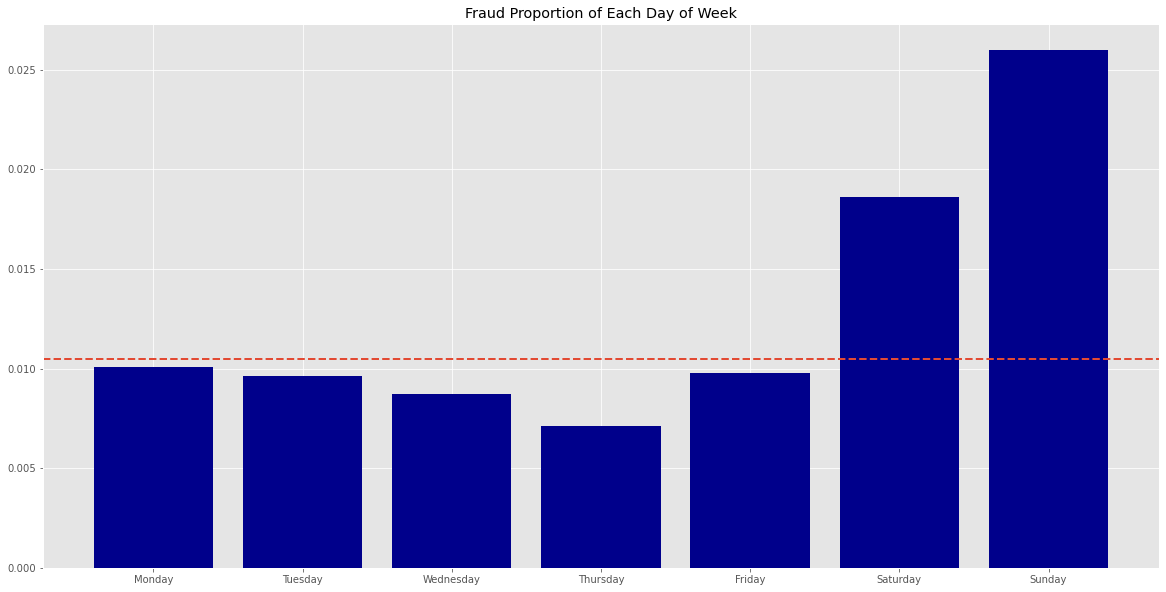

In [27]:
plt.style.use('ggplot')
fig,ax=plt.subplots(figsize=(20,10))
plt.bar(data=y_dow,x=y_dow.index,height='Fraud',color='darkblue')
#ax.set_ylim(bottom=0.013)
ax.axhline(y=y_avg,ls='--',lw=2)
# add text label
# for i,v in enumerate(y_dow.index):
#     ax.text(v,y_dow.loc[i,'Fraud']+0.0001,round(y_dow.loc[i,'Fraud'],5),horizontalalignment='center',fontsize=15)
plt.title('Fraud Proportion of Each Day of Week')
plt.show()

#### Merchant State risk table

In [28]:
# statistical smoothing
c=4;nmid=20;y_avg=train_test['Fraud'].mean()
y_state=train_test.groupby('Merch state')['Fraud'].mean()
num=train_test.groupby('Merch state').size()
y_state_smooth=y_avg+(y_state-y_avg)/(1+np.exp(-(num-nmid)/c))
data['Merch state_risk']=data['Merch state'].map(y_state_smooth)
# print(y_avg)
# print(y_state)
# print(num)
# print(y_state_smooth)
data.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,dow,dow_risk,Merch state_risk
0,1,5142190439,2006-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,Sunday,0.025994,0.007970
1,2,5142183973,2006-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0,Sunday,0.025994,0.003304
2,3,5142131721,2006-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0,Sunday,0.025994,0.017282
3,4,5142148452,2006-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0,Sunday,0.025994,0.007970
4,5,5142190439,2006-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,Sunday,0.025994,0.007970


In [29]:
data['Merch state'].unique()

array(['TN', 'MA', 'MD', 'OH', 'GA', 'IL', 'TX', 'WA', 'WI', 'NJ', 'FL',
       'NY', 'CA', 'MS', 'VA', 'MO', 'PA', 'NC', 'WV', 'CT', 'KS', 'OR',
       'SC', 'MI', 'MN', 'KY', 'ME', 'CO', 'DC', 'AK', 'IA', 'NH', 'MT',
       'OK', 'unknown', 'NV', 'RI', 'NE', 'AZ', 'NM', 'UT', 'ID', 'SD',
       'AL', 'DE', 'BC', 'LA', 'QC', 'IN', 'ON', 'VT', 'ND', 'AR', 'MB',
       'HI', 'WY', 'PQ', 'NS', 'AB', 'US'], dtype=object)

In [30]:
y_state=y_state.reset_index()
cats=['TN', 'MA', 'MD', 'OH', 'GA', 'IL', 'TX', 'WA', 'WI', 'NJ', 'FL',
       'NY', 'CA', 'MS', 'VA', 'MO', 'PA', 'NC', 'WV', 'CT', 'KS', 'OR',
       'SC', 'MI', 'MN', 'KY', 'ME', 'CO', 'DC', 'AK', 'IA', 'NH', 'MT',
       'OK', 'unknown', 'NV', 'RI', 'NE', 'AZ', 'NM', 'UT', 'ID', 'SD',
       'AL', 'DE', 'BC', 'LA', 'QC', 'IN', 'ON', 'VT', 'ND', 'AR', 'MB',
       'HI', 'WY', 'PQ', 'NS', 'AB', 'US']
y_state['Merch state']=pd.Categorical(y_state['Merch state'],categories=cats,ordered=True)
y_state=y_state.sort_values('Fraud',ascending=False).head(15)
y_state=y_state.set_index('Merch state')
y_state

,Fraud
Merch state,
IN,0.084388
UT,0.044099
OR,0.024634
OH,0.024563
NY,0.023937
WA,0.020518
NM,0.018519
PA,0.018118
DC,0.017632


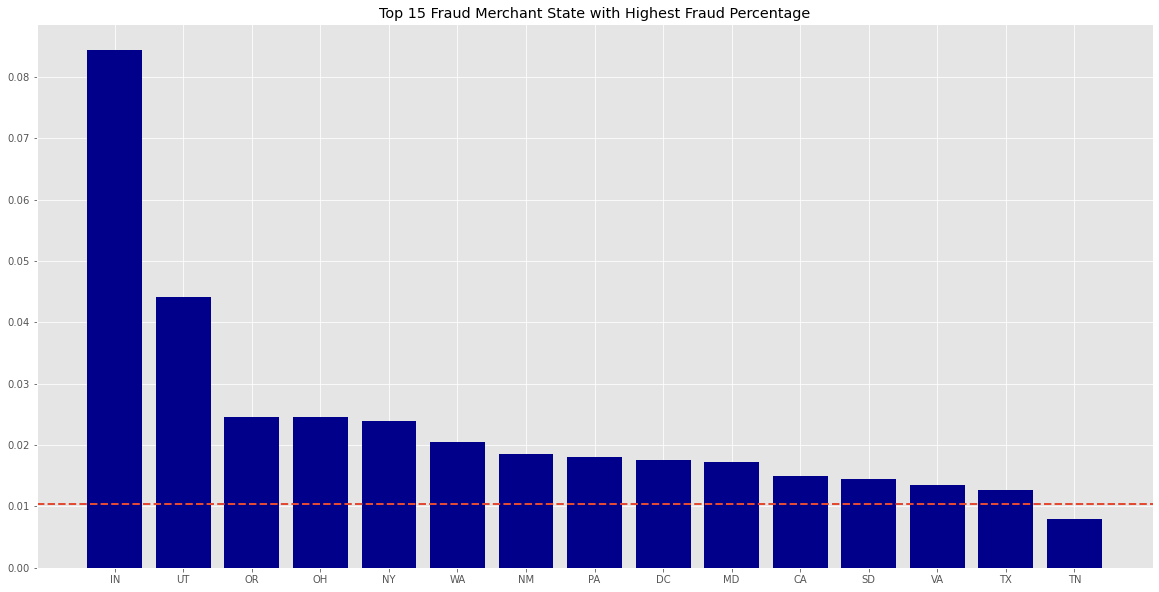

In [31]:
plt.style.use('ggplot')
fig,ax=plt.subplots(figsize=(20,10))
plt.bar(data=y_state,x=y_state.index,height='Fraud',color='darkblue')
#ax.set_ylim(bottom=0.013)
ax.axhline(y=y_avg,ls='--',lw=2)
plt.title('Top 15 Fraud Merchant State with Highest Fraud Percentage')
plt.show()

### Benford's Law Variable

In [32]:
# remove all the transactions from Fedex 
cleaned_data=data[data["Merch description"].str.match(r"[Ff][Ee][Dd][Ee][Xx]")==False].copy()
cleaned_data['Amount']=cleaned_data['Amount'].astype(str)

In [33]:
cleaned_data.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,dow,dow_risk,Merch state_risk
1,2,5142183973,2006-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0,Sunday,0.025994,0.003304
2,3,5142131721,2006-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0,Sunday,0.025994,0.017282
7,8,5142191182,2006-01-01,6098208200062,MIAMI COMPUTER SUPPLY,OH,45429.0,P,230.32,0,Sunday,0.025994,0.024563
8,9,5142258629,2006-01-01,602608969534,FISHER SCI ATL,GA,30091.0,P,62.11,0,Sunday,0.025994,0.001150
13,14,5142124791,2006-01-01,5725000466504,CDW*GOVERNMENT INC,IL,60061.0,P,106.89,0,Sunday,0.025994,0.006167


In [34]:
def n_low(df):
    return ((df['Amount'].str.extract(r"([1-9])")==1)|(df['Amount'].str.extract(r"([1-9])")=='2')).sum()

In [35]:
cardnums=cleaned_data.groupby('Cardnum').apply(n_low)
cardnums['n']=cleaned_data.groupby('Cardnum')['Amount'].count()
cardnums['n_low']=cleaned_data.groupby('Cardnum').apply(n_low)
cardnums=cardnums[['n','n_low']]
cardnums['n_high']=cardnums['n']-cardnums['n_low']

In [36]:
cardnums['n_low']=cardnums["n_low"].replace(0,1)
cardnums['n_high']=cardnums["n_high"].replace(0,1)

In [37]:
cardnums['R']=1.096*cardnums['n_low']/cardnums['n_high']
cardnums['1/R']=1/cardnums["R"]
cardnums['U']=cardnums[['R','1/R']].max(axis=1)

In [38]:
from math import e
cardnums['t']=(cardnums['n']-15)/3
cardnums["U*"]=1+((cardnums['U']-1)/(1+e**-cardnums['t']))

In [39]:
cardnums.sort_values('U*',ascending=False)[0:40].to_csv('Top 40 Cardnum.csv')

In [40]:
merchnums=cleaned_data.groupby('Merchnum').apply(n_low)
merchnums['n']=cleaned_data.groupby('Merchnum')['Amount'].count()
merchnums['n_low']=cleaned_data.groupby('Merchnum').apply(n_low)
merchnums=merchnums[['n','n_low']]
merchnums['n_high']=merchnums['n']-merchnums['n_low']

In [41]:
merchnums['n_low']=merchnums["n_low"].replace(0,1)
merchnums['n_high']=merchnums["n_high"].replace(0,1)

In [42]:
merchnums['R']=1.096*merchnums['n_low']/merchnums['n_high']
merchnums['1/R']=1/merchnums["R"]
merchnums['U']=merchnums[['R','1/R']].max(axis=1)

In [43]:
merchnums['t']=(merchnums['n']-15)/3
merchnums["U*"]=1+((merchnums['U']-1)/(1+e**-merchnums['t']))

In [44]:
merchnums.sort_values('U*',ascending=False)[0:40].to_csv('Top 40 Merchnum.csv')

In [45]:
data.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,dow,dow_risk,Merch state_risk
0,1,5142190439,2006-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,Sunday,0.025994,0.007970
1,2,5142183973,2006-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0,Sunday,0.025994,0.003304
2,3,5142131721,2006-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0,Sunday,0.025994,0.017282
3,4,5142148452,2006-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0,Sunday,0.025994,0.007970
4,5,5142190439,2006-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,Sunday,0.025994,0.007970


### Make some new entities for variables

In [46]:
# remove decimal
data.loc[data['Merch zip']!='unknown','Merch zip']=data.loc[data['Merch zip']!='unknown','Merch zip'].apply(lambda x:int(x))

In [47]:
data['Merch zip']=data['Merch zip'].apply(str) 
data['Cardnum']=data['Cardnum'].apply(str) 

In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96397 entries, 0 to 96752
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Recnum             96397 non-null  int64         
 1   Cardnum            96397 non-null  object        
 2   Date               96397 non-null  datetime64[ns]
 3   Merchnum           96397 non-null  object        
 4   Merch description  96397 non-null  object        
 5   Merch state        96397 non-null  object        
 6   Merch zip          96397 non-null  object        
 7   Transtype          96397 non-null  object        
 8   Amount             96397 non-null  float64       
 9   Fraud              96397 non-null  int64         
 10  dow                96397 non-null  object        
 11  dow_risk           96397 non-null  float64       
 12  Merch state_risk   96397 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(7)
memory 

In [49]:
data1=data.copy()

In [50]:
data['fulladdress']=data['Merch state']+data['Merch zip']
data['Merchnum_Merch description']=data['Merchnum']+data['Merch description']
data['Merchnum_fulladdress']=data['Merchnum']+data['fulladdress']
data['Cardnum_fulladdress']=data['Cardnum']+data['fulladdress']

In [51]:
data.head(1)

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,dow,dow_risk,Merch state_risk,fulladdress,Merchnum_Merch description,Merchnum_fulladdress,Cardnum_fulladdress
0,1,5142190439,2006-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,P,3.62,0,Sunday,0.025994,0.00797,TN38118,5509006296254FEDEX SHP 12/23/09 AB#,5509006296254TN38118,5142190439TN38118


In [52]:
print(data.columns)
print(len(data.columns))

Index(['Recnum', 'Cardnum', 'Date', 'Merchnum', 'Merch description',
       'Merch state', 'Merch zip', 'Transtype', 'Amount', 'Fraud', 'dow',
       'dow_risk', 'Merch state_risk', 'fulladdress',
       'Merchnum_Merch description', 'Merchnum_fulladdress',
       'Cardnum_fulladdress'],
      dtype='object')
17


In [53]:
for field in list(data.iloc[:,np.r_[3:7]].columns):
    data['Cardnum_'+field]=data.Cardnum+data[field]

In [54]:
print(data.columns)
print(len(data.columns))

Index(['Recnum', 'Cardnum', 'Date', 'Merchnum', 'Merch description',
       'Merch state', 'Merch zip', 'Transtype', 'Amount', 'Fraud', 'dow',
       'dow_risk', 'Merch state_risk', 'fulladdress',
       'Merchnum_Merch description', 'Merchnum_fulladdress',
       'Cardnum_fulladdress', 'Cardnum_Merchnum', 'Cardnum_Merch description',
       'Cardnum_Merch state', 'Cardnum_Merch zip'],
      dtype='object')
21


In [55]:
data['amount_quantile']=data['Amount'].apply(lambda x : 'low' if x <=33.48 else ( 'medium low'if x<=137.98 else ('medium high' if x<=428.2 else 'high')))
data['amount_manual']=data['Amount'].apply(lambda x : 'smaller than 100' if x <=100 else ( 'between 100 and 500'if x<=500 else ('between 500 and 1000' if x<=1000 else ('between 1000 and 3000' if x<=3000 else 'more than 3000'))))

In [56]:
data.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,...,fulladdress,Merchnum_Merch description,Merchnum_fulladdress,Cardnum_fulladdress,Cardnum_Merchnum,Cardnum_Merch description,Cardnum_Merch state,Cardnum_Merch zip,amount_quantile,amount_manual
0,1,5142190439,2006-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,P,3.62,0,...,TN38118,5509006296254FEDEX SHP 12/23/09 AB#,5509006296254TN38118,5142190439TN38118,51421904395509006296254,5142190439FEDEX SHP 12/23/09 AB#,5142190439TN,514219043938118,low,smaller than 100
1,2,5142183973,2006-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803,P,31.42,0,...,MA1803,61003026333SERVICE MERCHANDISE #81,61003026333MA1803,5142183973MA1803,514218397361003026333,5142183973SERVICE MERCHANDISE #81,5142183973MA,51421839731803,low,smaller than 100
2,3,5142131721,2006-01-01,4503082993600,OFFICE DEPOT #191,MD,20706,P,178.49,0,...,MD20706,4503082993600OFFICE DEPOT #191,4503082993600MD20706,5142131721MD20706,51421317214503082993600,5142131721OFFICE DEPOT #191,5142131721MD,514213172120706,medium high,between 100 and 500
3,4,5142148452,2006-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118,P,3.62,0,...,TN38118,5509006296254FEDEX SHP 12/28/09 AB#,5509006296254TN38118,5142148452TN38118,51421484525509006296254,5142148452FEDEX SHP 12/28/09 AB#,5142148452TN,514214845238118,low,smaller than 100
4,5,5142190439,2006-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,P,3.62,0,...,TN38118,5509006296254FEDEX SHP 12/23/09 AB#,5509006296254TN38118,5142190439TN38118,51421904395509006296254,5142190439FEDEX SHP 12/23/09 AB#,5142190439TN,514219043938118,low,smaller than 100


In [57]:
data.columns.tolist()

['Recnum',
 'Cardnum',
 'Date',
 'Merchnum',
 'Merch description',
 'Merch state',
 'Merch zip',
 'Transtype',
 'Amount',
 'Fraud',
 'dow',
 'dow_risk',
 'Merch state_risk',
 'fulladdress',
 'Merchnum_Merch description',
 'Merchnum_fulladdress',
 'Cardnum_fulladdress',
 'Cardnum_Merchnum',
 'Cardnum_Merch description',
 'Cardnum_Merch state',
 'Cardnum_Merch zip',
 'amount_quantile',
 'amount_manual']

In [58]:
attributes_all=[
 'Cardnum',
 'Merchnum',
 'Merch description',
 'Merch state',
 'Merch zip',
 'fulladdress',
 'Merchnum_Merch description',
 'Merchnum_fulladdress',
 'Cardnum_fulladdress',
 'Cardnum_Merchnum',
 'Cardnum_Merch description',
 'Cardnum_Merch state',
 'Cardnum_Merch zip']

In [59]:
# attributes=['Cardnum','Merchnum','Merch state','Merch zip','Cardnum_Merchnum','Cardnum_Merch state' ,'Cardnum_Merch zip']

In [60]:
# attributes

In [61]:
df1=data.copy()
vars=data.copy()
df1['check_date']=df1.Date
df1['check_record']=df1.Recnum

In [62]:
# 18 mins
import timeit
from timeit import default_timer as timer
start = timeit.default_timer()
for entity in attributes_all:
    try: print('Run time for the last entity ----------------- {}s'.format(timeit.default_timer() - st))
    except: print('')
    st = timeit.default_timer()
       
    ## Day-since variables:   
    df_l = df1[['Recnum', 'Date', entity]]
    df_r = df1[['check_record', 'check_date', entity, 'Amount']]    
    temp = pd.merge(df_l, df_r, left_on = entity, right_on = entity)   
    temp1 = temp[temp.Recnum > temp.check_record][['Recnum','Date','check_date']]\
                                                   .groupby('Recnum')[['Date', 'check_date']].last()
    mapper = (temp1.Date - temp1.check_date).dt.days
    vars[entity + '_day_since'] = vars.Recnum.map(mapper)
    vars[entity + '_day_since'].fillna((vars.Date - pd.to_datetime('2006-01-01')).dt.days, inplace = True)
    print('\n' + entity + '_day_since ---> Done')   
    ## Frequency & Amount variables:   
    for time in [0,1,3,7,14,30,60,90]:       
        temp2 = temp[(temp.check_date >= (temp.Date - dt.timedelta(time))) &\
                       (temp.Recnum >= temp.check_record)][['Recnum', entity, 'Amount']]       
        col_name = entity + '_count_' + str(time)    
        mapper2 = temp2.groupby('Recnum')[entity].count()      
        vars[col_name] = vars.Recnum.map(mapper2)        
        print(col_name + ' ---> Done')       
        vars[entity + '_avg_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
        vars[entity + '_max_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
        vars[entity + '_med_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
        vars[entity + '_total_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].sum())
        vars[entity + '_actual/avg_' + str(time)] = vars['Amount'] / vars[entity + '_avg_' + str(time)]
        vars[entity + '_actual/max_' + str(time)] = vars['Amount'] / vars[entity + '_max_' + str(time)]
        vars[entity + '_actual/med_' + str(time)] = vars['Amount'] / vars[entity + '_med_' + str(time)]
        vars[entity + '_actual/toal_' + str(time)] = vars['Amount'] / vars[entity + '_total_' + str(time)]       
        print(entity + ' amount variables over past '+ str(time) + ' ---> Done')
print('Total run time: {}mins'.format((timeit.default_timer() - start)/60))




Cardnum_day_since ---> Done
Cardnum_count_0 ---> Done
Cardnum amount variables over past 0 ---> Done
Cardnum_count_1 ---> Done
Cardnum amount variables over past 1 ---> Done
Cardnum_count_3 ---> Done
Cardnum amount variables over past 3 ---> Done
Cardnum_count_7 ---> Done
Cardnum amount variables over past 7 ---> Done
Cardnum_count_14 ---> Done
Cardnum amount variables over past 14 ---> Done
Cardnum_count_30 ---> Done
Cardnum amount variables over past 30 ---> Done
Cardnum_count_60 ---> Done
Cardnum amount variables over past 60 ---> Done
Cardnum_count_90 ---> Done
Cardnum amount variables over past 90 ---> Done
Run time for the last entity ----------------- 7.881368500000008s

Merchnum_day_since ---> Done
Merchnum_count_0 ---> Done
Merchnum amount variables over past 0 ---> Done
Merchnum_count_1 ---> Done
Merchnum amount variables over past 1 ---> Done
Merchnum_count_3 ---> Done


C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_5604/239025498.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_total_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].sum())
C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_5604/239025498.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_actual/avg_' + str(time)] = vars['Amount'] / vars[entity + '_avg_' + str(time)]
C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_5604/239025498.py:33: PerformanceWarning: DataFrame is highly f

Merchnum amount variables over past 3 ---> Done


C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_5604/239025498.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name] = vars.Recnum.map(mapper2)
C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_5604/239025498.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_avg_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_5604/239025498.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `fram

Merchnum_count_7 ---> Done


C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_5604/239025498.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_med_' + str(time)] = vars.Recnum.map(temp2.groupby('Recnum')['Amount'].median())


Merchnum amount variables over past 7 ---> Done
Merchnum_count_14 ---> Done
Merchnum amount variables over past 14 ---> Done
Merchnum_count_30 ---> Done
Merchnum amount variables over past 30 ---> Done
Merchnum_count_60 ---> Done
Merchnum amount variables over past 60 ---> Done
Merchnum_count_90 ---> Done
Merchnum amount variables over past 90 ---> Done
Run time for the last entity ----------------- 42.28637040000001s


C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_5604/239025498.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_day_since'] = vars.Recnum.map(mapper)



Merch description_day_since ---> Done
Merch description_count_0 ---> Done
Merch description amount variables over past 0 ---> Done
Merch description_count_1 ---> Done
Merch description amount variables over past 1 ---> Done
Merch description_count_3 ---> Done
Merch description amount variables over past 3 ---> Done
Merch description_count_7 ---> Done
Merch description amount variables over past 7 ---> Done
Merch description_count_14 ---> Done
Merch description amount variables over past 14 ---> Done
Merch description_count_30 ---> Done
Merch description amount variables over past 30 ---> Done
Merch description_count_60 ---> Done
Merch description amount variables over past 60 ---> Done
Merch description_count_90 ---> Done
Merch description amount variables over past 90 ---> Done
Run time for the last entity ----------------- 9.033934400000021s

Merch state_day_since ---> Done
Merch state_count_0 ---> Done
Merch state amount variables over past 0 ---> Done
Merch state_count_1 ---> Done

In [63]:
print(len(vars.columns))

972


In [66]:
# relative velocity: RATIO OF THE SHORT-TERM velocity to a long-term averaged velocity
# #applications at that entity seen in a short time window {today or past day} compared to # applications at that entity over a longer time window {past 3,7,14,30 days}.
# velocity change variables
start=timeit.default_timer()
for att in attributes_all:
    for d in ['0','1']:
        for dd in ['3','7','14','30','60','90']:
            vars[att+'_count_'+d+'_by_'+dd]=vars[att+'_count_'+d]/(vars[att+'_count_'+dd]/float(dd))
print(f'Total run time: {timeit.default_timer() - start}s')

C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_5604/4190846556.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[att+'_count_'+d+'_by_'+dd]=vars[att+'_count_'+d]/(vars[att+'_count_'+dd]/float(dd))


Total run time: 0.8896919999997408s


In [67]:
print(len(vars.columns))

1131


In [70]:
vars.to_csv('vars_final.csv')